# MATH 521 - Numerical Analysis of Differential Equations

Christoph Ortner, 01/2024

## Assignment 1 : One Dimension

**Name:** Jincong Li

**Student ID:** 60539939

### Q1: Implementation of  Model Problem [20] 

Recall our first boundary value problem that we studied in class, 
$$ \begin{aligned}
 & - u'' = f, \quad x \in (0, 1), \\ 
 & u(0) = u(1) = 0. 
 \end{aligned}
$$
We reformulated this in the weak form: find $u \in H^1_0(0, 1)$ such that 
$$
   \int_0^1 u' v' dx = \int_0^1 f v dx \qquad \forall v \in H^1_0(0, 1). 
$$
We then defined the finite element method as follows: 
- Specify the nodes for a mesh: $0 = x_0 < x_1 <\dots < x_N = 1$
- Specify the space $V_h = \{ u_h : \text{cts, p.w. affine w.r.t. } (x_j)_j \}$
- Fine $u_h \in V_h$ such that 
$$
  \int_0^1 u_h' v_h' dx = \int_0^1 f v_h dx \qquad \forall v_h \in H^1_0(0, 1). 
$$

**Your task:** Implement this numerical scheme, using mid-point quadrature (as in class) solve it with $f(x) = 1$, plot both the exact solution and the finite element solution (for $N = 15$).

In [4]:
# import Pkg; Pkg.add("Plots")
using Plots, LaTeXStrings
# import Pkg; Pkg.add("LaTeXStrings")

   Resolving package versions...


    Updating `C:\Users\Conro\.julia\environments\v1.10\Project.toml`
  [b964fa9f] + LaTeXStrings v1.3.1
  No Changes to `C:\Users\Conro\.julia\environments\v1.10\Manifest.toml`


In [6]:
# outline of the implementation 
using Plots, LaTeXStrings
function assemble_system(X, f)
    # input 
    #   X : list of grid points, e.g. as Vector{Float64}
    #   f : function to evaluate f(x)
   
    N = length(X) - 1    # number of elements
    A = zeros(N+1, N+1)  # should be sparse, but let's not worry
    F = zeros(N+1)
    
    for j = 1:N
        # compute the contributions to F and A from the element (xⱼ₋₁, xⱼ)
        # and write them into A, F
        ξⱼ = 0.5 * (X[j]+X[j+1])  # midpoint for quadrature
        hⱼ = X[j+1] - X[j]        # mesh size in current element 
    end
   
    return A, F
end

# My suggestion is that `assemble_system` returns 
# A and F ignoring the boundary condition i.e. for the full 
# N+1 DOFs. We can then reduce those to the required size 
# for solving only for the free DOFs. (Think about why this works!)

N = 15 
X = range(0, 1, length = N+1)
f = x -> 1.0
A, F = assemble_system(X, f) 
U = zeros(N+1)
U[2:N] = A[2:N, 2:N] \ F[2:N];

LinearAlgebra.SingularException: LinearAlgebra.SingularException(1)

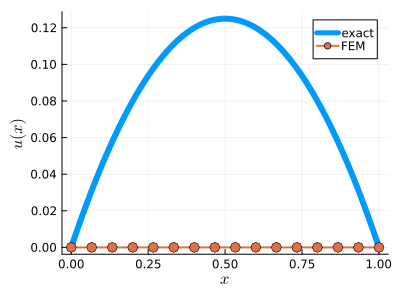

In [7]:
# the postprocessing and visualization should be done in a separate cell
# from the computation. 

xp = range(0, 1, 100)
u = xp -> 0.5 * xp .* (1-xp)

plot(; xlabel = L"x", ylabel = L"u(x)", size = (400, 300))
plot!(xp, u, lw=6, label = "exact")
plot!(X, U, lw=2, m=:o, ms=5, label = "FEM")


---

### Q2-pre [5]

To solve the following question you will need a little extra piece of information that I hinted at in class but didn't really work out completely: in one dimension, point evaluation is a continuous / bounded operation in the typical Sobolev spaces we encounter. Concretely, the following is true: let $\hat{x} \in (0, 1)$ and let $v \in C^1([0, 1])$ then 
$$
  \big| v(\hat{x}) - v(0) \big| \leq C \| v' \|_{L^2(0, 1)} 
$$
for some suitable constant $C > 0$. Prove this statement. 


**Solution for Q2-pre:**


### Q2: Neumann Boundary Condition [15]

Consider the boundary value problem
$$
\begin{aligned} 
     - u'' &= f, \quad x \in (0, 1), \\ 
    u(0) &= 0, \\ 
    u'(1) &= g.
\end{aligned} 
$$
where $a, f$ are continuous in $[0, 1]$, $a(x) > 0$, $g \in \mathbb{R}$. 

(1) Derive the weak form. Prove that it has a unique solution.

*HINT: the correct function space this time is not $H^1_0(0, 1)$.  Remember from class how we chose the test function!*

(2) Formulate the corresponding finite element method. Prove that it has a unique solution.

(3) Prove that the FEM solution is the best approximation in a natural norm that you should specify. 

**Solution (Q2.1)**


**Solution (Q2.2)**
 


**Solution (Q2.3)**



### Q3:  Implementation of Q2 [10]

Implement the method you defined in Q2. Copy-paste your code from Q1 and adapt it. 

*HINT: only a single line needs to be added to the assemble, then the solution script that enforces the boundary condition needs to be adapted suitably.*

Use it to solve the BVP from Q2 with $f = 1$ and $g = -1/2$ and $N = 10$. Plot the exact solution and the FEM solution.

In [ ]:
# Solution to Q3


In [ ]:
# postprocessing and visualization
